In [1]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
sys.path.append('/home/massoale/Bureau/Stage_M2/stage_diags/diagnostics_pkg/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp
import dask.array as da
from joblib import Parallel, delayed

# Periodic case

la simulation chargée est: dahu_619
depuis: dahu_downsized


{'NX': 256, 'NY': 256, 'nl': 1.0, 'Lx': 502.65482457, 'f0': 2.0, 'beta': 1.0, 'k_f': 1.0, 'sigma_f': 1.0, 'bc_fac': -1.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 0.00077160493827, 'n_hyper': 4.0, 'hEkb': 0.00390625, 'tend': 1576800000000.0, 'dt_out': 0.05}


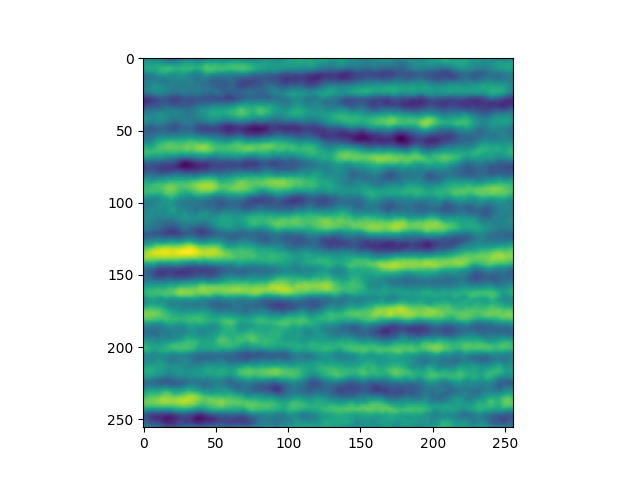

In [215]:


# Number of simulation
n = 619

# Choose between 'local' or 'dahu' or 'dahu_downsized'
where = 'dahu_downsized'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

elif where == 'dahu_downsized':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
    Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
#dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})
dataset=nc.Dataset(Path+filenames[0])

# # Load variables in chunks
# t = dataset['time'].data
# x = dataset['x'].data
# y = dataset['y'].data
# psi = dataset['psi'].isel(level=0).data
# q = dataset['q'].isel(level=0).data
# print("shape of psi :",np.shape(psi))


t=dataset.variables['time'][:]
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]
psi=dataset.variables['psi'][:,0,:,:]
q=dataset.variables['q'][:,0,:,:]
# Lecture des paramètres :
if where == 'dahu_downsized':
    param = io.read_params(Path_bis)
    nx = 256
    ny = 256
    
    param['NX'] = nx
    param['NY'] = ny
else:
    param = io.read_params(Path)
    nx = int(param['NX'])
    ny = int(param['NY'])

f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']
print(param)
plt.figure()
plt.imshow(psi[-2, :, :])



In [4]:
#################################################################Aide de Chat GPT########################################################################""


def fft2d_RI_vect_optimized(psi, Lx, nx, ny, time_tab):
    real_part_tab = np.zeros((len(time_tab), ny, nx), dtype=float)
    imag_part_tab = np.zeros((len(time_tab), ny, nx), dtype=float)
    dx = Lx / nx
    dy = Lx / ny

    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi
    
    Kx, Ky = np.meshgrid(kx, ky)

    for i, time_sel in enumerate(time_tab):
        psi_data = psi[time_sel, :, :]
        fft_result = np.fft.fft2(psi_data) * 2 / (nx * ny)
        
        real_part_tab[i, :, :] = np.real(fft_result)
        imag_part_tab[i, :, :] = np.imag(fft_result)

    return real_part_tab, imag_part_tab, Kx, Ky

def fft2d_RI(psi, Lx, nx, ny):
    
    dx = Lx / nx
    dy = Lx / ny

    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi  
    
    kx_shifted = np.fft.fftshift(kx)
    ky_shifted = np.fft.fftshift(ky)
    
    Kx, Ky = np.meshgrid(kx_shifted, ky_shifted)
    

    # 2D Fourier Transform
    fft_result = np.fft.fft2(psi) / (nx * ny)  
    fft_shifted = np.fft.fftshift(fft_result,axes=(1,2))  # Shift zero frequency component to center

    print(np.shape(fft_shifted))
    return fft_shifted, Kx, Ky



def pulsation_vect_optimized(real_part_tab, imag_part_tab, t,time_tab):
    dt = t[time_tab[1]] - t[time_tab[0]]
    count = real_part_tab.shape[0] - 1

    pulsation_sum = np.zeros_like(real_part_tab[0], dtype=complex)
    pulsation_var = np.zeros_like(real_part_tab[0], dtype=complex)
    for t in range(count):
        real_t, imag_t = real_part_tab[t], imag_part_tab[t]
        real_t1, imag_t1 = real_part_tab[t + 1], imag_part_tab[t + 1]
        
        amp_t = np.sqrt(real_t**2 + imag_t**2)
        psi_t = (real_t + 1j * imag_t) / np.max(amp_t)
        
        amp_t1 = np.sqrt(real_t1**2 + imag_t1**2)
        psi_t1 = (real_t1 + 1j * imag_t1) / np.max(amp_t1)

        psi_conj_interp = (np.conjugate(psi_t1) + np.conjugate(psi_t)) / 2
        psi_norm_interp = (amp_t + amp_t1) / 2

        dreal_dt = (real_t1 - real_t) / dt
        dimag_dt = (imag_t1 - imag_t) / dt
        pterm = psi_conj_interp * (dreal_dt + 1j * dimag_dt)

        psi_squared_t = real_t**2 + imag_t**2
        psi_squared_t1 = real_t1**2 + imag_t1**2
        sterm = (psi_squared_t1 - psi_squared_t) / dt

        pulsation_t = 1 / (1j * psi_norm_interp) * (pterm - sterm)
        pulsation_sum += np.abs(pulsation_t)
        pulsation_var += pulsation_t**2

    pulsation_observed_mean = pulsation_sum / count
    pulsation_var = pulsation_var / count 
    return pulsation_observed_mean, pulsation_var



<class 'numpy.ma.core.MaskedArray'>
(280, 256, 256)
(-0.00020348554312801893+1.3094599968959449e-20j)
(280, 256, 256)
shape fft mean (256, 256)
k_rhines = 0.25
Zono = 4.0
Occupation = 0.050000000000434384
(256, 256)
u (280, 256, 256)
mean total energy 241.04642574451873
sum of the mean total fluc and mean energy 241.04642573481323


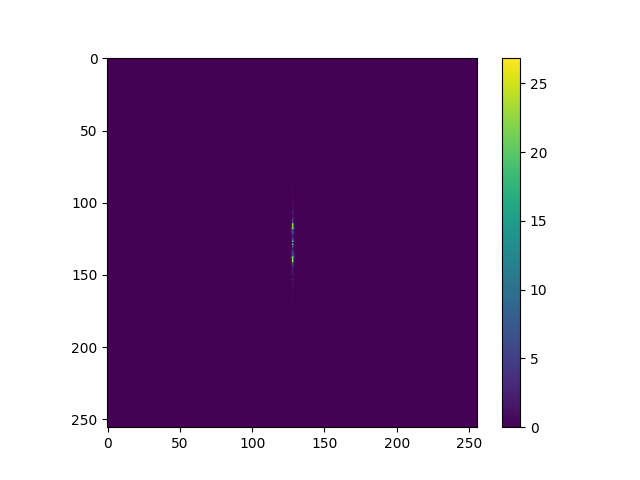

In [217]:
#Computing the energy contain in the rossby waves
time_sel = np.arange(1, len(t), 5)
print(type(psi))



psi_mean=np.mean(psi[time_sel,:,:],axis=0)

fft,Kx,Ky = fft2d_RI(psi[time_sel,:,:],Lx,nx,ny)
print(np.mean(fft,axis=(0,1,2)))
fft_fluc,Kx,Ky = fft2d_RI(psi[time_sel,:,:]-psi_mean[None,:,:],Lx,nx,ny)
fft_mean = np.mean(fft,axis=0)
print("shape fft mean",np.shape(fft_mean))
#Computing k_rhines and useful parameters

epsilon = sigma_f**2
r = hEkb
k_rhines = beta**0.5/(epsilon/r)**(1/4)
Oc = (epsilon/(beta**2*r*(Lx/(2*np.pi))**4))**(1/4) #k_Rh/k_L   
Zo = (beta**2*epsilon/r**5)**(1/20)

print('k_rhines =',k_rhines)    
print("Zono =",Zo)
print("Occupation =",Oc)

n = Lx*(k_rhines)/(2*np.pi)
dx = x[-1]-x[-2]

# Compute the energy spectrums
energy_mat = np.abs(fft)**2*(Kx**2+Ky**2)
energy_mat_fluc = np.abs(fft_fluc)**2*(Kx**2+Ky**2)
energy_mat_mean = np.abs(fft_mean)**2*(Kx**2+Ky**2)


# Compute the magnitude of the wave numbers
k_mag = np.sqrt(Kx**2 + Ky**2)

# # mask = np.zeros_like(k_mag)
# # mask[k_mag<k_rhines]=1
# mask = np.ones_like(k_mag)
# # Filter out the energies for k < krhines
# energy_filtered = energy_mat*mask

# Sum the total energy for the filtered values
total_energy_rhines_fft = np.sum(energy_mat,axis=(1,2))

print(np.shape(psi_mean))
u,v=op.calc_uv(psi[time_sel,:,:],dx,bc_fac)
u_mean,v_mean=op.calc_uv(psi_mean[None,:,:],dx,bc_fac)

print("u",np.shape(u))
total_energy_rhines = np.mean(0.5 * ( (u)**2 + (v)**2 ),axis=(1,2))#op.calc_en(psi[time_sel,:,:]-psi_mean,q[time_sel,:,:]-q_mean,dx,bc_fac=bc_fac)/Lx**2

##

#Calculating the total energy
#psi_fluc=psi[time_sel,:,:]-np.mean(psi[time_sel,:,:],axis=0)
#q_fluc=q[time_sel,:,:]-np.mean(q[time_sel,:,:],axis=0)
#total_energy_rhines=np.sum(psi_fluc*q_fluc,axis=(1,2))
#energy_totale=op.calc_en(psi[time_sel,:,:], q[time_sel,:,:],dx,bc_fac=bc_fac)/Lx**2
#energy_totale_fft,_,_= fft2d_RI(psi[time_sel,:,:],Lx,nx,ny)

#energy_ratio=total_energy_rhines/np.mean(energy_totale,axis=0)
#energy_ratio_fft=total_energy_rhines_fft/np.mean(energy_totale,axis=0)/2
# Plot the total energy
# plt.figure()
# plt.subplot(211)
# plt.plot(time_sel,total_energy_rhines)
# plt.xlabel('Time')
# plt.ylabel('Energy below k_rhines / Total Energy')
# plt.title('Energy ratio for $\\sqrt{Kx^2 + Ky^2} < krhines$')
# plt.subplot(212)
# plt.plot(time_sel,total_energy_rhines_fft/2)
# plt.show()
total_mean_energy_fft=np.mean(np.sum(energy_mat,axis=(1,2)),axis=0)
total_mean_energy_fluc_fft=np.mean(np.sum(energy_mat_fluc,axis=(1,2)),axis=0)

total_mean_energy_fft_mean=np.sum(energy_mat_mean[:,:],axis=(0,1))
print("mean total energy",total_mean_energy_fft)
print("sum of the mean total fluc and mean energy",total_mean_energy_fluc_fft+total_mean_energy_fft_mean)
plt.figure()
plt.imshow(np.abs(fft_mean))
plt.colorbar()
plt.show()

(280, 256, 256)
(5.124353001429289e-11+1.5124453924701004e-20j)
(280, 256, 256)
k_rhines = 0.25
Zono = 4.0
Occupation = 0.050000000000434384


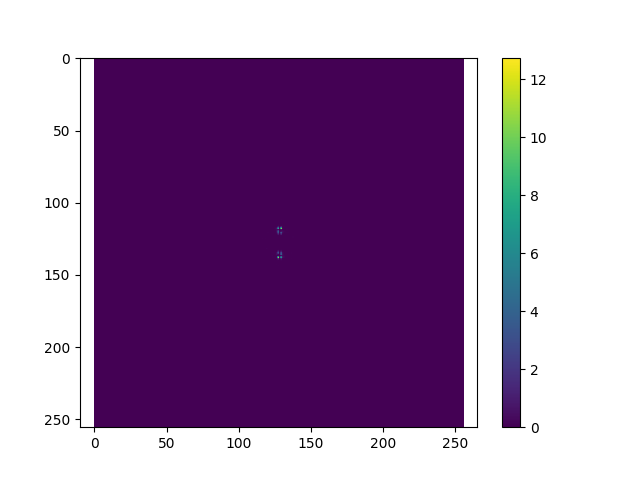

mean total energy in the waves 102.82536570515063
ratio of the mean total energy in the waves and the total energy 0.882371480683444
energy in the mean flow/total energy 6.4265827603113676e-12


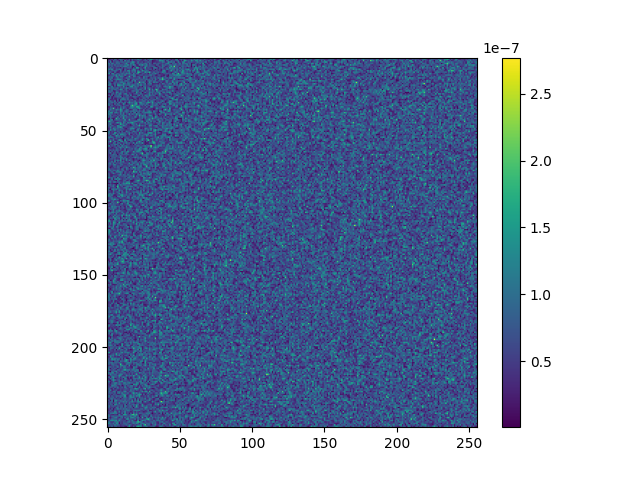

In [221]:
#Computing the energy contain in the rossby waves
time_sel = np.arange(1, len(t), 5)
psi_mean=np.mean(psi[time_sel,:,:],axis=0)

fft,Kx,Ky = fft2d_RI(psi[time_sel,:,:]-psi_mean,Lx,nx,ny)
print(np.mean(fft,axis=(0,1,2)))
fft_fluc,Kx,Ky = fft2d_RI(psi[time_sel,:,:]-psi_mean[None,:,:],Lx,nx,ny)
fft_mean = np.mean(fft,axis=0)

#Computing k_rhines and useful parameters

epsilon = sigma_f**2
r = hEkb
k_rhines = beta**0.5/(epsilon/r)**(1/4)
Oc = (epsilon/(beta**2*r*(Lx/(2*np.pi))**4))**(1/4) #k_Rh/k_L   
Zo = (beta**2*epsilon/r**5)**(1/20)

print('k_rhines =',k_rhines)    
print("Zono =",Zo)
print("Occupation =",Oc)

n = Lx*(k_rhines)/(2*np.pi)
dx = x[-1]-x[-2]

# Compute the energy spectrums
energy_mat = np.abs(fft)**2*(Kx**2+Ky**2)
energy_mat_fluc = np.abs(fft_fluc)**2*(Kx**2+Ky**2)
energy_mat_mean = np.abs(fft_mean)**2*(Kx**2+Ky**2)


# Compute the magnitude of the wave numbers
k_mag = np.sqrt(Kx**2 + Ky**2)

mask = np.zeros_like(k_mag)
mask[(k_mag<k_rhines) ]=1 #| (Kx==0) 

# Filter out the energies for k < krhines
energy_filtered = energy_mat*mask
plt.figure()
plt.imshow(np.mean(energy_filtered,axis=0))
plt.colorbar()#np.mean(energy_filtered,axis=0))
plt.axis('equal')
plt.show()

# Sum the total energy for the filtered values
total_energy_rhines_fft = np.mean(np.sum(energy_filtered,axis=(1,2)),axis=0)
total_mean_energy_fft=np.mean(np.sum(energy_mat,axis=(1,2)),axis=0)
total_mean_energy_fluc_fft=np.mean(np.sum(energy_mat_fluc,axis=(1,2)),axis=0)

total_mean_energy_fft_mean=np.sum(energy_mat_mean[:,:],axis=(0,1))

print("mean total energy in the waves",total_energy_rhines_fft)
print("ratio of the mean total energy in the waves and the total energy",total_energy_rhines_fft/total_mean_energy_fft)
print("energy in the mean flow/total energy",total_mean_energy_fft_mean/total_mean_energy_fft)

plt.figure()
plt.imshow(np.abs(fft_mean))
plt.colorbar()
plt.show()

jet oscillations account for rossby waves the take part in the budget

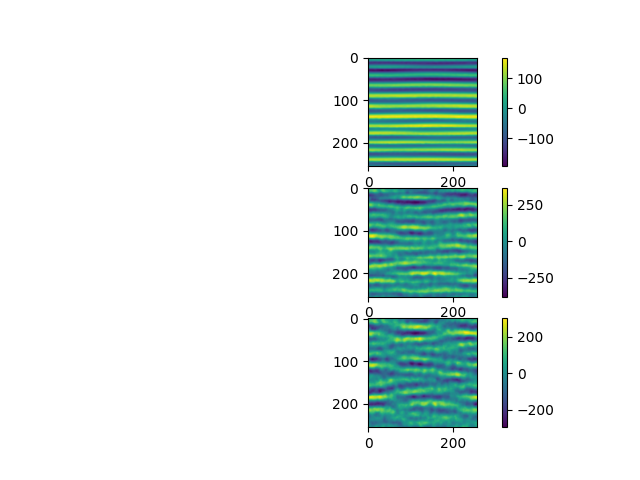

In [219]:
plt.figure()
plt.subplot(311)
plt.imshow(psi_mean)
plt.colorbar()
plt.subplot(312)
plt.imshow(psi[4,:,:])
plt.colorbar()
plt.subplot(313)
plt.imshow(psi[4,:,:]-psi_mean)
plt.colorbar()
plt.show()

(140, 256, 256)
(256, 256)
(140, 256, 256)
[[ 2.9972622e-07 -1.4713833e-06 -4.8705510e-06 ...  2.0163400e-06
   7.1389336e-06  7.5476510e-06]
 [ 4.2131969e-06 -1.4041151e-06 -2.3841858e-07 ...  2.3978098e-06
  -2.7707645e-06 -3.0653819e-08]
 [ 4.6321324e-07  5.5858067e-07 -2.8610231e-07 ...  1.5633447e-06
   1.1580331e-06 -4.2234149e-07]
 ...
 [-1.3623919e-06 -2.1798271e-06 -1.0735648e-05 ...  2.4523054e-06
   5.0680978e-06  1.7983573e-06]
 [ 5.4495676e-08 -4.6321325e-06  1.2860979e-05 ...  5.1770890e-06
  -1.2534006e-05  8.7193084e-06]
 [ 8.2833430e-06  8.7193084e-06 -6.5531049e-06 ... -1.0735648e-05
   5.8855330e-06 -7.7520099e-06]]


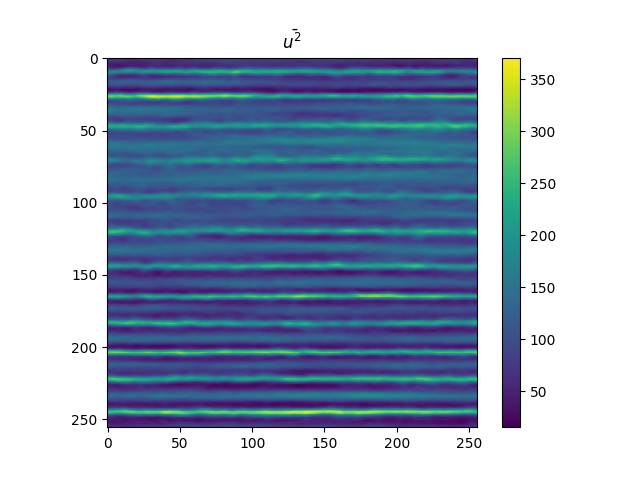

In [103]:
print(np.shape(psi[time_sel,:,:]))
print(np.shape(psi_mean))
print(np.shape(psi[time_sel,:,:]-psi_mean))
print(np.mean(psi[time_sel,:,:]-psi_mean,axis=0))
plt.figure()
plt.imshow(np.mean(1/2*(u**2+v**2),axis=0))
plt.colorbar()
plt.title(r'$\bar{u^2}$')
plt.show()

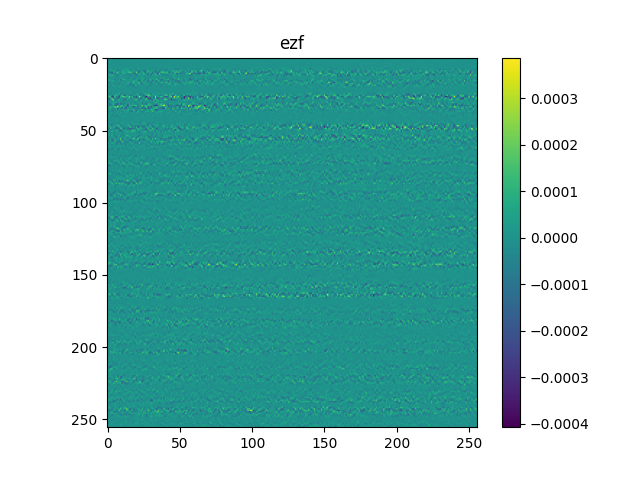

In [107]:

plt.figure()
plt.imshow(np.mean(1/2*(u**2+v**2),axis=0)-1/2* ( u_mean[0,:,:]**2+v_mean[0,:,:]**2 + np.mean(((u-u_mean[0,:,:])**2+(v-v_mean[0,:,:])**2),axis=0) ))
plt.colorbar()
plt.title(r'ezf')
plt.show()

# Doing this for several values of zonostrophy



In [59]:
simu_numbers=np.array([59,51,63,64,68,70,69,68,619]) #Zonostrophic simu
t_conv=np.array([200,300,200,350,300,-200,300,300,0])
where_list =  ['dahu' for i in range(len(simu_numbers)-1)] + ['dahu_downsized']


#Arrays where I will store the parameters:


Zo_tab_l=np.zeros_like(simu_numbers,dtype='float')
Oc_tab_l=np.zeros_like(simu_numbers,dtype='float')
E_wave_tab=np.zeros_like(simu_numbers,dtype='float')
E_meanflow_tab=np.zeros_like(simu_numbers,dtype='float')
E_turb_tab=np.zeros_like(simu_numbers,dtype='float')


f0_tab=np.zeros_like(simu_numbers,dtype='float')
beta_tab=np.zeros_like(simu_numbers,dtype='float')
hEkb_tab=np.zeros_like(simu_numbers,dtype='float')
dh_tab=np.zeros_like(simu_numbers,dtype='float')
Lx_tab=np.zeros_like(simu_numbers,dtype='float')
nx_tab=np.zeros_like(simu_numbers,dtype='float')
ny_tab=np.zeros_like(simu_numbers,dtype='float')
sigma_f_tab=np.zeros_like(simu_numbers,dtype='float')
bc_fac_tab=np.zeros_like(simu_numbers,dtype='float')
nu_hyper_tab=np.zeros_like(simu_numbers,dtype='float')
n_hyper_tab=np.zeros_like(simu_numbers,dtype='float')





for i,n in enumerate(simu_numbers):
    #Choose between 'local' or 'dahu'
    where=where_list[i]
    
    # Reading the netcdf file
    if where == 'local':
        if n < 10:
            simu_name = 'outdir_000' + str(n)
        elif n < 100 and n >= 10:
            simu_name = 'outdir_00' + str(n)
            Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
    elif where == 'dahu':
        simu_name = 'dahu_' + str(n)
        Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

    elif where == 'dahu_downsized':
        simu_name = 'dahu_' + str(n)
        Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
        Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

    else:
        print('Error: where not recognized')
        sys.exit()

    print('la simulation chargée est: ' + simu_name)
    print("depuis: " + where)

    filenames = ['/vars.nc']

    # Open the dataset using xarray
    #dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})

    dataset=nc.Dataset(Path+filenames[0])

    
    t_start=t_conv[i]
    t=dataset.variables['time'][t_start:]
    
    x=dataset.variables['x'][:]
    y=dataset.variables['y'][:]
    psi=dataset.variables['psi'][t_start:,0,:,:]
    #q=dataset.variables['q'][t_start:,0,:,:]
    # Lecture des paramètres :
    if where == 'dahu_downsized':
        param = io.read_params(Path_bis)
        nx = 256
        ny = 256

        param['NX'] = nx
        param['NY'] = ny
    else:
        param = io.read_params(Path)
        nx = int(param['NX'])
        ny = int(param['NY'])


    f0= param['f0']
    beta=param['beta']
    hEkb=param['hEkb']
    dh=param['dh'][0]
    Lx=param['Lx']
    k_f=param['k_f']
    sigma_f=param['sigma_f']
    bc_fac=param['bc_fac']
    nu_hyper=param['nu_hyper']
    n_hyper=param['n_hyper']
    dt_out=param['dt_out']

    epsilon=sigma_f**2
    r=f0*hEkb/(2*dh)

    k_rhines = beta**0.5/(epsilon/r)**(1/4)
     
    Zo = (beta**2*epsilon/r**5)**(1/20)
    
    #Computing the energy contain in the rossby waves
    time_sel = np.arange(1, len(t), 3)
    print("shape de psi time sel",np.shape(psi[time_sel,:,:]))
    psi_mean=np.mean(psi[time_sel,:,:],axis=0)

    
    fft,Kx,Ky = fft2d_RI(psi[time_sel,:,:],Lx,nx,ny)

    fft_fluc,Kx,Ky = fft2d_RI(psi[time_sel,:,:]-psi_mean[None,:,:],Lx,nx,ny)
    
    fft_mean = np.mean(fft,axis=0)

    # Compute the energy spectrums
    energy_mat = np.abs(fft)**2*(Kx**2+Ky**2)
    energy_mat_fluc = np.abs(fft_fluc)**2*(Kx**2+Ky**2)
    energy_mat_mean = np.abs(fft_mean)**2*(Kx**2+Ky**2)

    #Computing total energy
    total_mean_energy_fft=np.mean(np.sum(energy_mat,axis=(1,2)),axis=0)

    total_mean_energy_fluc_fft=np.mean(np.sum(energy_mat_fluc,axis=(1,2)),axis=0)

    total_mean_energy_fft_mean=np.sum(energy_mat_mean[:,:],axis=(0,1))
    
    # Compute the magnitude of the wave numbers
    k_mag = np.sqrt(Kx**2 + Ky**2)
    
    mask = np.zeros_like(k_mag)
    mask[(k_mag<k_rhines) ]=1

    mask_turb=np.zeros_like(k_mag)
    mask_turb[(k_mag>k_rhines) ]=1
    
    
    # Filter out the energies for k < krhines
    energy_filtered = energy_mat_fluc*mask

    

    #Computing energy in the waves
    total_energy_rhines_fft = np.mean(np.sum(energy_filtered,axis=(1,2)),axis=0)
    E_wave_tab[i]=total_energy_rhines_fft/total_mean_energy_fft
    
    #filter the energy for k>krhines
    energy_turb = energy_mat_fluc*mask_turb
    total_energy_turb=np.mean(np.sum(energy_turb,axis=(1,2)),axis=0)
    E_turb_tab[i]=total_energy_turb/total_mean_energy_fft

    #Computing the energy in the mean flow
    total_mean_energy_fft_mean=np.sum(energy_mat_mean[:,:],axis=(0,1))
    E_meanflow_tab[i]=total_mean_energy_fft_mean/total_mean_energy_fft

    #computing zonostrophy:

    Zo_tab_l[i]= Zo
    Oc_tab_l[i]= (epsilon/(beta**2*r*(Lx/(2*np.pi))**4))**(1/4) 
    
    

    # #filling the arrays
    # f0_tab[i]=f0
    # beta_tab[i]=beta
    # hEkb_tab[i]=hEkb
    # dh_tab[i]=dh
    # Lx_tab[i]=Lx
    # nx_tab[i]=nx
    # ny_tab[i]=ny
    # sigma_f_tab[i]=sigma_f
    # bc_fac_tab[i]=bc_fac
    # nu_hyper_tab[i]=nu_hyper
    # n_hyper_tab[i]=n_hyper
    




la simulation chargée est: dahu_59
depuis: dahu
856
shape de psi time sel (285, 512, 512)
(285, 512, 512)
(285, 512, 512)
la simulation chargée est: dahu_51
depuis: dahu
285
shape de psi time sel (95, 512, 512)
(95, 512, 512)
(95, 512, 512)
la simulation chargée est: dahu_63
depuis: dahu
807
shape de psi time sel (269, 512, 512)
(269, 512, 512)
(269, 512, 512)
la simulation chargée est: dahu_64
depuis: dahu
426
shape de psi time sel (142, 512, 512)
(142, 512, 512)
(142, 512, 512)
la simulation chargée est: dahu_68
depuis: dahu
278
shape de psi time sel (93, 512, 512)
(93, 512, 512)
(93, 512, 512)
la simulation chargée est: dahu_70
depuis: dahu
200
shape de psi time sel (67, 512, 512)
(67, 512, 512)
(67, 512, 512)
la simulation chargée est: dahu_69
depuis: dahu
199
shape de psi time sel (66, 512, 512)
(66, 512, 512)
(66, 512, 512)
la simulation chargée est: dahu_68
depuis: dahu
278
shape de psi time sel (93, 512, 512)
(93, 512, 512)
(93, 512, 512)
la simulation chargée est: dahu_619
dep

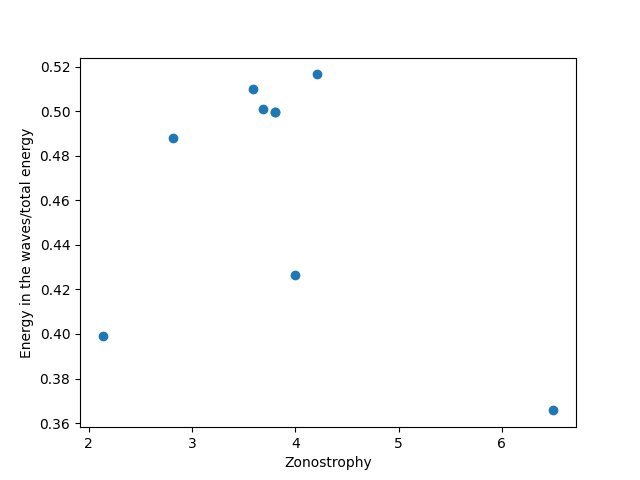

[ 59  51  63  64  68  70  69  68 619]
[2.13321431 3.6858751  2.81758509 3.5927681  3.80025551 6.5000993
 4.21327242 3.80025551 4.        ]


In [64]:
plt.figure()
plt.scatter(Zo_tab_l,E_wave_tab)
plt.xlabel("Zonostrophy")
plt.ylabel("Energy in the waves/total energy")
plt.savefig("figures/Energy_diags/Zonostrophy_energy_wave.png")
plt.show()
print(simu_numbers)
print(Zo_tab_l)

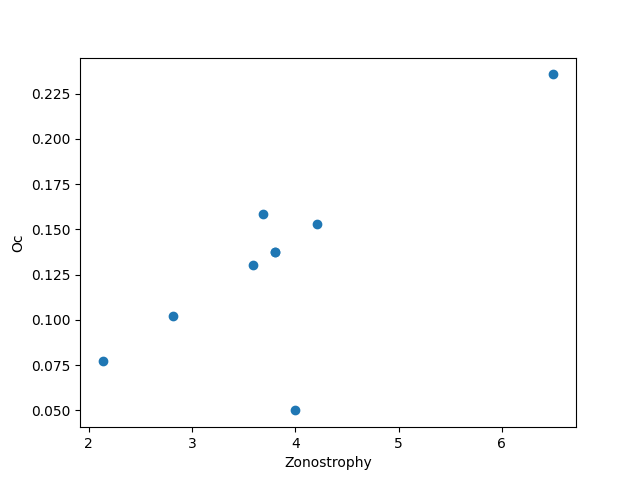

In [61]:
plt.figure()
plt.scatter(Zo_tab_l,Oc_tab_l)
plt.xlabel("Zonostrophy")
plt.ylabel("Oc")
plt.show()


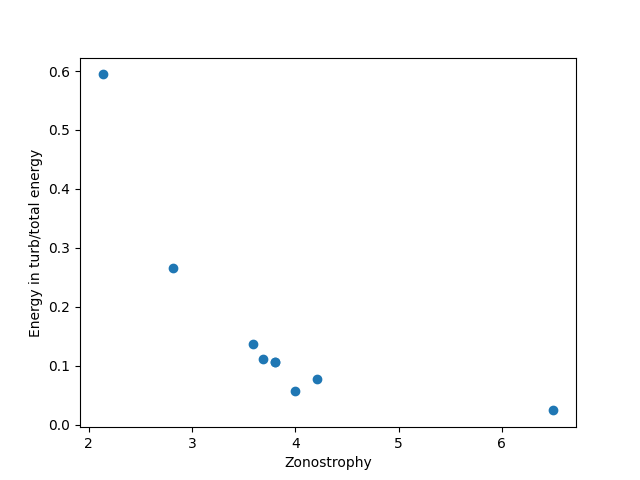

[ 59  51  63  64  68  70  69  68 619]
[2.13321431 3.6858751  2.81758509 3.5927681  3.80025551 6.5000993
 4.21327242 3.80025551 4.        ]


In [65]:
plt.figure()
plt.scatter(Zo_tab_l,E_turb_tab)
plt.xlabel("Zonostrophy")
plt.ylabel("Energy in turb/total energy")
plt.savefig("figures/Energy_diags/Zonostrophy_energy_turb.png")
plt.show()
print(simu_numbers)
print(Zo_tab_l)

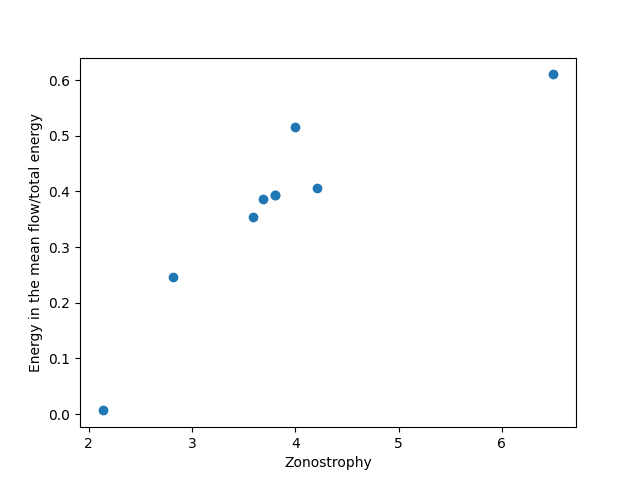

[ 59  51  63  64  68  70  69  68 619]
[2.13321431 3.6858751  2.81758509 3.5927681  3.80025551 6.5000993
 4.21327242 3.80025551 4.        ]


In [66]:
plt.figure()
plt.scatter(Zo_tab_l,E_meanflow_tab)
plt.xlabel("Zonostrophy")
plt.ylabel("Energy in the mean flow/total energy")
plt.savefig("figures/Energy_diags/Zonostrophy_energy_meanflow.png")
plt.show()
print(simu_numbers)
print(Zo_tab_l)

la simulation chargée est: dahu_59
depuis: dahu
1056
N= 512 Nt= 1056
(1056, 512, 512)
(1056, 512, 512)
N= 512 Nt= 1056
(1056, 512, 512)
Error = 0.0 %
Energy_diss_drag/Energy_injected 97.376 %


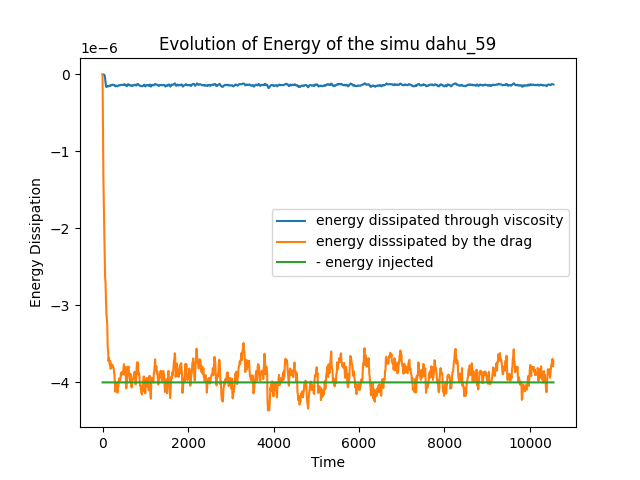

la simulation chargée est: dahu_51
depuis: dahu
585
N= 512 Nt= 585
(585, 512, 512)
(585, 512, 512)
N= 512 Nt= 585
(585, 512, 512)
Error = -9.999999475275377 %
Energy_diss_drag/Energy_injected 84.062 %


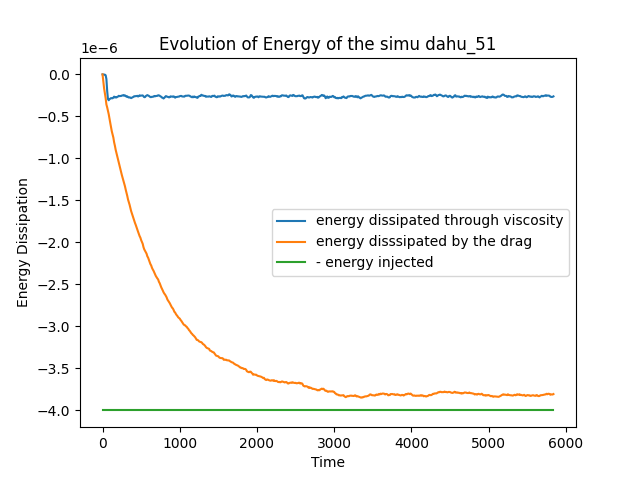

la simulation chargée est: dahu_63
depuis: dahu
1007
N= 512 Nt= 1007
(1007, 512, 512)
(1007, 512, 512)
N= 512 Nt= 1007
(1007, 512, 512)
Error = -0.0 %
Energy_diss_drag/Energy_injected 94.151 %


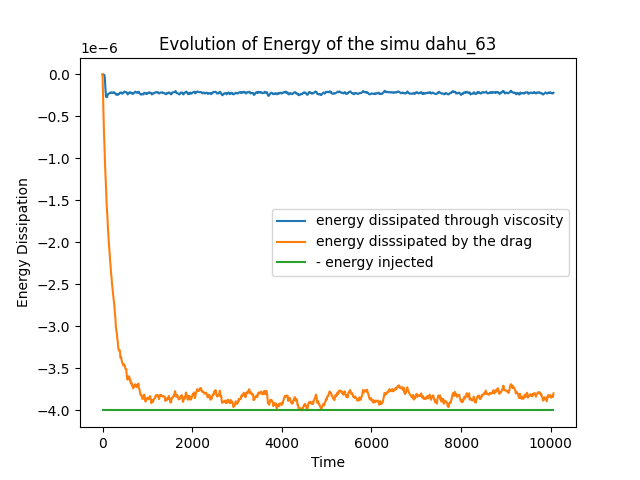

la simulation chargée est: dahu_64
depuis: dahu
776
N= 512 Nt= 776
(776, 512, 512)
(776, 512, 512)
N= 512 Nt= 776
(776, 512, 512)
Error = -4.99999943246937 %
Energy_diss_drag/Energy_injected 88.504 %


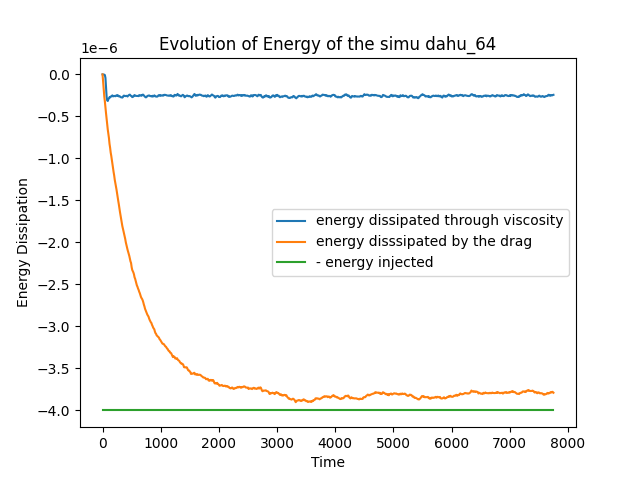

la simulation chargée est: dahu_68
depuis: dahu
578
N= 512 Nt= 578
(578, 512, 512)
(578, 512, 512)
N= 512 Nt= 578
(578, 512, 512)
Error = -10.000000391091044 %
Energy_diss_drag/Energy_injected 83.644 %


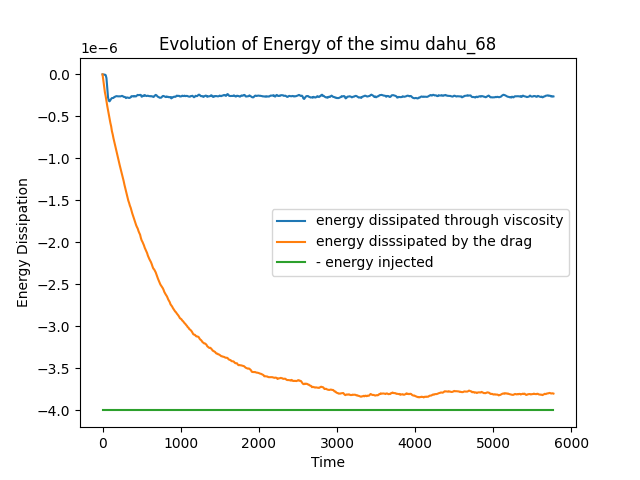

la simulation chargée est: dahu_70
depuis: dahu
1604
N= 512 Nt= 1604
(1604, 512, 512)
(1604, 512, 512)
N= 512 Nt= 1604
(1604, 512, 512)
Error = -32.499997843047765 %
Energy_diss_drag/Energy_injected 61.006 %


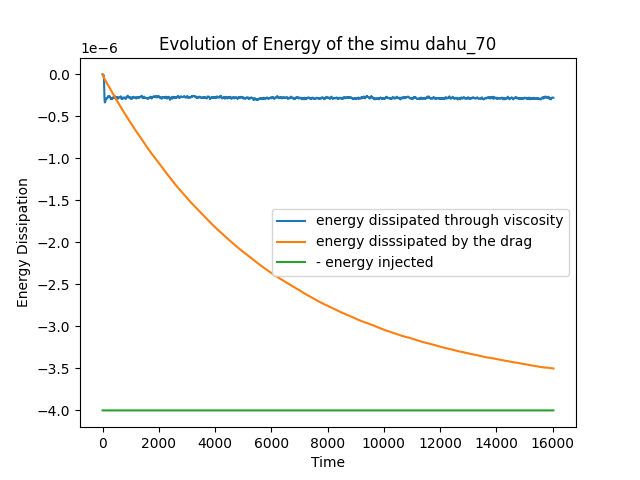

la simulation chargée est: dahu_69
depuis: dahu
499
N= 512 Nt= 499
(499, 512, 512)
(499, 512, 512)
N= 512 Nt= 499
(499, 512, 512)
Error = -17.499997392819765 %
Energy_diss_drag/Energy_injected 74.939 %


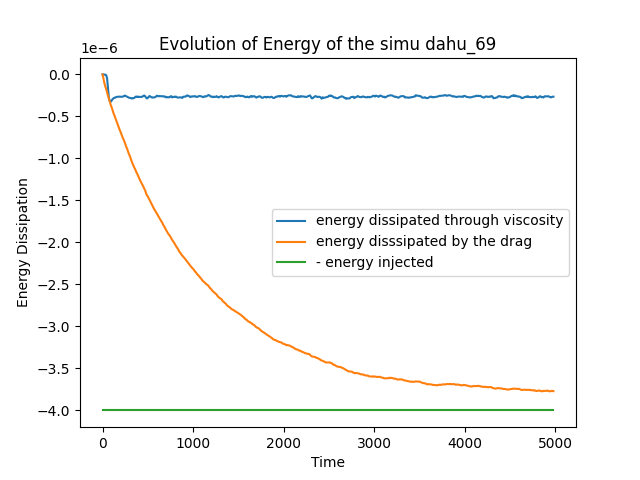

la simulation chargée est: dahu_68
depuis: dahu
578
N= 512 Nt= 578
(578, 512, 512)
(578, 512, 512)
N= 512 Nt= 578
(578, 512, 512)
Error = -10.000000391091044 %
Energy_diss_drag/Energy_injected 83.644 %


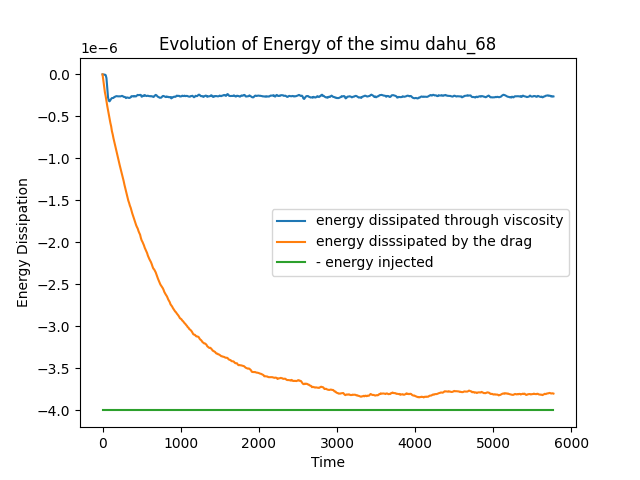

la simulation chargée est: dahu_619
depuis: dahu_downsized
1400
N= 256 Nt= 1400
(1400, 256, 256)
(1400, 256, 256)
N= 256 Nt= 1400
(1400, 256, 256)
Error = -5.51365 %
Energy_diss_drag/Energy_injected 94.172 %


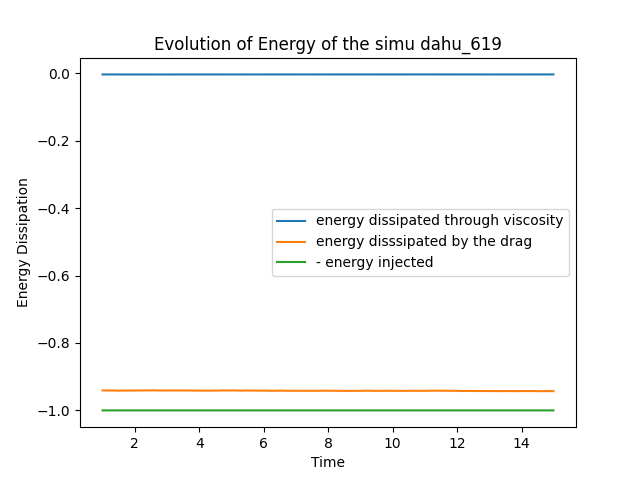

In [58]:
simu_numbers=np.array([59,51,63,64,68,70,69,68,619]) #Zonostrophic simu

where_list =  ['dahu' for i in range(len(simu_numbers)-1)] + ['dahu_downsized']







for i,n in enumerate(simu_numbers):
    #Choose between 'local' or 'dahu'
    where=where_list[i]
    
    # Reading the netcdf file
    if where == 'local':
        if n < 10:
            simu_name = 'outdir_000' + str(n)
        elif n < 100 and n >= 10:
            simu_name = 'outdir_00' + str(n)
            Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
    elif where == 'dahu':
        simu_name = 'dahu_' + str(n)
        Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

    elif where == 'dahu_downsized':
        simu_name = 'dahu_' + str(n)
        Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
        Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

    else:
        print('Error: where not recognized')
        sys.exit()

    print('la simulation chargée est: ' + simu_name)
    print("depuis: " + where)

    filenames = ['/vars.nc']

    # Open the dataset using xarray
    #dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})

    dataset=nc.Dataset(Path+filenames[0])

    t=dataset.variables['time'][:]
    # if len(t>498):
    #     t_start=-800
    # else:
    #     t_start=80
    # t=t[t_start:]
    print(len(t))
    x=dataset.variables['x'][:]
    y=dataset.variables['y'][:]
    psi=dataset.variables['psi'][:,0,:,:]
    q=dataset.variables['q'][:,0,:,:]
    # Lecture des paramètres :
    if where == 'dahu_downsized':
        param = io.read_params(Path_bis)
        nx = 256
        ny = 256

        param['NX'] = nx
        param['NY'] = ny
    else:
        param = io.read_params(Path)
        nx = int(param['NX'])
        ny = int(param['NY'])


    f0= param['f0']
    beta=param['beta']
    hEkb=param['hEkb']
    dh=param['dh'][0]
    Lx=param['Lx']
    k_f=param['k_f']
    sigma_f=param['sigma_f']
    bc_fac=param['bc_fac']
    nu_hyper=param['nu_hyper']
    n_hyper=param['n_hyper']
    dt_out=param['dt_out']

    epsilon=sigma_f**2
    r=f0*hEkb/(2*dh)

    k_rhines = beta**0.5/(epsilon/r)**(1/4)
        
    time_start =0

    psi_data = psi[-time_start:, :, :]
    q_data = q[-time_start:, :, :]

    dx=x[-1]/x.shape[0]
    dy=y[-1]/y.shape[0]

    Lx=x[-1] #Lengh of the domain
    Ly=y[-1] #Width of the domain

    #Calculating the energy
    energy_totale=op.calc_en(psi_data, q_data,dx,bc_fac=bc_fac)/Lx**2


    enstro=op.calc_lap(psi_data,dx,bc_fac=bc_fac)**2/2
    print(np.shape(enstro))
    enstro_mean=np.mean(enstro,axis=(1,2))
    #Calculating the total enstrophy for each snapshots
    enstro_tot=np.sum(enstro,axis=(1,2))


    dx=x[-1]/x.shape[0]
    r=f0*hEkb/(dh*2)


    #energy injectée :
    energy_inj=np.zeros_like(energy_totale)
    energy_inj[:]=sigma_f**2
    energy_diss=-2*energy_totale*r
    #enstro_diss=-2*nu_hyper*enstro_mean

    #Calculating the enerrgy dissipated by hyper-viscosity
    lap_vorticity=op.calc_lap(q_data,dx,bc_fac=bc_fac)

    if n_hyper==6:
        #palenstro_tot=np.sum(lap_vorticity**2,axis=(1,2))/Lx**2
        palenstro_tot=np.mean(lap_vorticity**2,axis=(1,2))
        enstro_diss=-nu_hyper*palenstro_tot 

    #Dans le cas ou l'hyper visocisté est égale à 4:
    elif n_hyper==4:    

        enstro_diss=nu_hyper*np.mean(lap_vorticity*q_data,axis=(1,2))

    mean_enstro_diss=float(np.mean(enstro_diss[:]))
    mean_energy_diss=float(np.mean(energy_diss[:]))
    mean_energy_inj=float(np.mean(energy_inj[:]))

    #computing the error of the energy dissipation
    print("Error =",round(-mean_energy_diss-mean_enstro_diss-mean_energy_inj,7)/mean_energy_inj*100,'%')


    ratioE=mean_energy_diss/mean_energy_inj*100
    print("Energy_diss_drag/Energy_injected",-round(ratioE,3),'%')

    plt.figure()

    plt.plot(t[-time_start:],enstro_diss,label='energy dissipated through viscosity')
    plt.plot(t[-time_start:],energy_diss,label='energy disssipated by the drag')
    plt.plot(t[-time_start:],-energy_inj,label='- energy injected')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Energy Dissipation')
    plt.title('Evolution of Energy of the simu '+str(simu_name))
    #plt.savefig('./figures/Energy_Dissipation_'+str(simu_name)+'.png')
    plt.show()


# closed Case

In [61]:
print(np.shape(psi_fluc),np.shape(q_fluc))
print(np.shape(psi_fluc*q_fluc))

(9, 2048, 2048) (9, 2048, 2048)
(9, 2048, 2048)


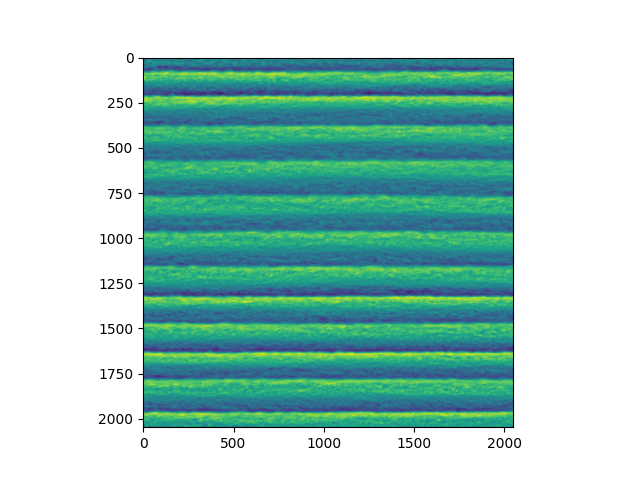

In [77]:
plt.figure()
plt.imshow(q_mean.compute())
plt.show()

la simulation chargée est: dahu_922
depuis: dahu_downsized
shape of psi : (1200, 256, 256)
{'NX': 160, 'NY': 160, 'nl': 1.0, 'Lx': 314.15926535897927, 'f0': 2.0, 'beta': 1.0, 'k_f': 1.0, 'sigma_f': 1.0, 'bc_fac': 0.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 0.00077160493827, 'n_hyper': 4.0, 'hEkb': 0.0016, 'tend': 1576800000000.0, 'dt_out': 0.02}


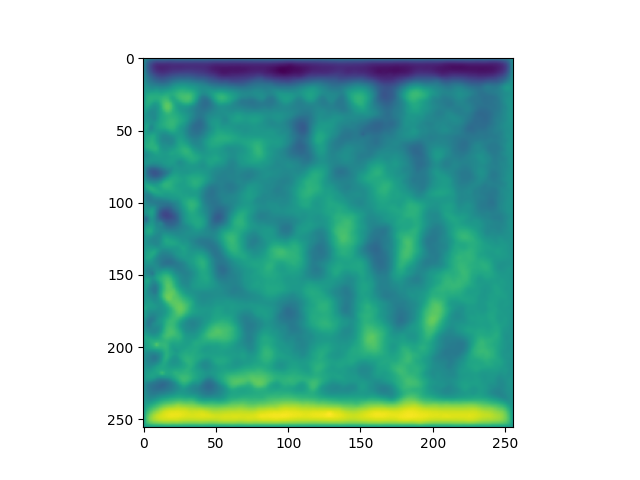

In [2]:


# Number of simulation
n = 922

# Choose between 'local' or 'dahu' or 'dahu_downsized'
where = 'dahu_downsized'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

elif where == 'dahu_downsized':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
    Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})


# Load variables in chunks
t = dataset['time'].data
x = dataset['x'].data
y = dataset['y'].data
psi = dataset['psi'].isel( level=0).data
q = dataset['q'].isel(level=0).data
print("shape of psi :",np.shape(psi))


# Lecture des paramètres :
if where == 'dahu_downsized':
    param = io.read_params(Path_bis)
    nx = 160
    ny = 160
    param['NX'] = nx
    param['NY'] = ny
else:
    param = io.read_params(Path)
    nx = int(param['NX'])
    ny = int(param['NY'])

f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']
print(param)
plt.figure()
plt.imshow(psi[-2, :, :])



In [3]:
q_prime = q - np.mean(q, axis=0)

In [4]:
def project_basin(q, m, n, L, norm = 0):
    ''' gives back complex amplitude that describes the projection of the field q onto the basin mode n,m. Projection on q gives the energy (in which case norm = 1 gives the proper normalisation), but works on any field.'''
    
    N  = np.shape(q)[-1]
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    mode = np.exp(-1j*np.pi*np.sqrt(m**2 + n**2)*x/L)*np.sin(m*np.pi*x/L)*np.sin(n*np.pi*y/L)
    
    delta = L/(N-1)
    
    if norm:
        coeff_mn = (-np.pi**2*(n**2 +m**2)/4)*(mode*q).sum(axis = (-2,-1))*delta**2
    else:
        coeff_mn = (mode*q).sum(axis = (-2,-1))*delta**2
        
    return coeff_mn

In [5]:
def project_basin(q, m, n, L, norm = 0):
    ''' gives back complex amplitude that describes the projection of the field q onto the basin mode n,m. Projection on q gives the energy (in which case norm = 1 gives the proper normalisation), but works on any field.'''
    
    N  = np.shape(q)[-1]
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    mode = np.exp(-1j*np.pi*np.sqrt(m**2 + n**2)*x/L)*np.sin(m*np.pi*x/L)*np.sin(n*np.pi*y/L)
    
    delta = L/(N-1)
    
    if norm:
        coeff_mn = (-np.pi**2*(n**2 +m**2)/4)*(mode*q).sum(axis = (-2,-1))*delta**2
    else:
        coeff_mn = (mode*q).sum(axis = (-2,-1))*delta**2
        
    return coeff_mn

In [6]:

def pulsation(psi_mn,t,t_sel):
    """Calculates the pulsation of the wave from the projection of the field psi on the mode (m,n)"""

    dt = t[t_sel[1]] - t[t_sel[0]]
    dpsi_mn_dt = (psi_mn[2:] - psi_mn[:-2]) / (2 * dt)
    
    pulsation_observed_brut = np.imag(np.conj(psi_mn[1:-1]) * dpsi_mn_dt) / np.abs(psi_mn[1:-1])**2
    pulsation_var = pulsation_observed_brut**2

    return pulsation_observed_brut,pulsation_var

In [7]:
# #Batch optimisation 
# time_sel = np.arange(0, len(t), 1, dtype=int)
# pi = np.pi

# def finding_parameters(m_sel, n_sel, time_sel,q, t):
#     """
#     Process a single (m, n) mode and return data for plotting if conditions are met.
#     """
#     # Finding the projection of the field on the mode
#     psi_mn = project_basin(q[time_sel, :, :], m_sel, n_sel, Lx, norm=0)
    
#     pulsation_observed_brut, pulsation_var = pulsation(psi_mn, t, time_sel)
    
#     pulsation_mode_theo = beta * Lx / (np.sqrt(m_sel**2 + n_sel**2) * 2 * np.pi)

    
#     rel_err = (np.abs(np.abs(np.mean(pulsation_observed_brut, axis=0) - np.abs(pulsation_mode_theo))) / np.abs(pulsation_mode_theo)).compute()
    
#     # Conditions to discriminate the modes with wave-like behavior
#     # condition1 = np.std(np.abs(np.sqrt(real**2 + imag**2)), axis=0) / np.mean(np.abs(np.sqrt(real**2 + imag**2)), axis=0) 
#     # condition2 = std / np.abs(np.mean(pulsation_observed_brut, axis=0)) 
#     condition3 = rel_err 

#     return condition1, condition2, condition3

# m_list = np.arange(0, 20, 1) 
# n_list = np.arange(0, 20, 1) 

# condition3_tab = np.zeros((len(n_list), len(m_list)))   

# # Batch processing
# batch_size = 5
# m_batches = [m_list[i:i + batch_size] for i in range(0, len(m_list), batch_size)]

# for batch_idx, m_batch in enumerate(m_batches):
#     print(f"Processing batch {batch_idx + 1}/{len(m_batches)}")
#     results = Parallel(n_jobs=-1)(delayed(finding_parameters)(m, n, time_sel, q_prime, t) for m in m_batch for n in n_list)
    
#     for idx, (m, n) in enumerate([(m, n) for m in m_batch for n in n_list]):
#         m_idx = np.where(m_list == m)[0][0]
#         n_idx = np.where(n_list == n)[0][0]
#         condition3_tab[n_idx, m_idx] = results[idx]


In [8]:
#Showing the parameters
epsilon=sigma_f**2
r=hEkb
k_rhines=beta**0.5/(epsilon/r)**(1/4)
n_rhines=Lx*(k_rhines)/(2*np.pi)


Oc = (epsilon/(beta**2*r*(Lx/(2*np.pi))**4))**(1/4) #k_Rh/k_L   
Zo = (beta**2*epsilon/r**5)**(1/20)
print('n_rhines =',n_rhines)    
print("Zono =",Zo)
print("Occupation =",Oc)

n_rhines = 9.999999999999998
Zono = 5.0
Occupation = 0.10000000000000002


In [13]:
from joblib import Parallel, delayed
import numpy as np

def energy_spectrum(psi_mn, m, n, L):
    E_mn_list = np.abs(psi_mn) ** 2 / L
    E_mn = np.mean(E_mn_list, axis=0)
    return E_mn, np.sqrt(m ** 2 + n ** 2)

def compute_spectrum_for_mode(m, n, q_prime, time_sel, Lx):
    psi_mn = project_basin(q_prime[time_sel, :, :], m, n, Lx, norm=0)
    E_mn, sqrt_mn = energy_spectrum(psi_mn, m, n, Lx)
    return m, n, E_mn, sqrt_mn

# Assuming `q_prime`, `t`, `Lx`, and `n_rhines` are already defined
time_sel = np.arange(0, len(t), 2, dtype=int)
E_mn_2D = np.zeros((int(n_rhines * 1.3), int(n_rhines * 1.3)))

# Parallel computation
results = Parallel(n_jobs=-1)(
    delayed(compute_spectrum_for_mode)(m, n, q_prime, time_sel, Lx)
    for m in range(1, np.shape(E_mn_2D)[0])
    for n in range(1, np.shape(E_mn_2D)[1])
)

# Collecting results
E_list_mn = []
sqrt_list = []

for m, n, E_mn, sqrt_mn in results:
    E_mn_2D[m-1, n-1] = E_mn
    E_list_mn.append(E_mn)
    sqrt_list.append(sqrt_mn)
    print(m)

print(np.shape(E_mn_2D))


1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
(12, 12)


In [22]:
from joblib import Parallel, delayed
import numpy as np

def energy_spectrum(psi_mn, m, n, L):
    E_mn_list = np.abs(psi_mn)**2 / L**2
    #E_mn = np.mean(E_mn_list, axis=0)
    return E_mn_list, np.sqrt(m**2 + n**2)

def compute_for_mn(m, n, q_prime, time_sel, Lx):
    psi_mn = project_basin(q_prime[time_sel, :, :], m, n, Lx, norm=0)
    E_mn, sqrt_mn = energy_spectrum(psi_mn, m, n, Lx)
    return E_mn, sqrt_mn

# Define the range of m and n
m_range = range(1,int(n_rhines*1.3) )
n_range = range(1, int(n_rhines*1.3))

# Create lists for results
results = Parallel(n_jobs=-1)(
    delayed(compute_for_mn)(m, n, q_prime, time_sel, Lx)
    for m in m_range
    for n in n_range
)

# Unpack results
E_list_mn = []
sqrt_list = []

E_mn_2D = np.zeros((len(time_sel),len(m_range), len(n_range)))

for (E_mn, sqrt_mn), m, n in zip(results, m_range, n_range):
    E_mn_2D[:,m-1, n-1] = E_mn
    E_list_mn.append(E_mn)
    sqrt_list.append(sqrt_mn)

print("Computation complete.")


Computation complete.


(600, 11, 11)


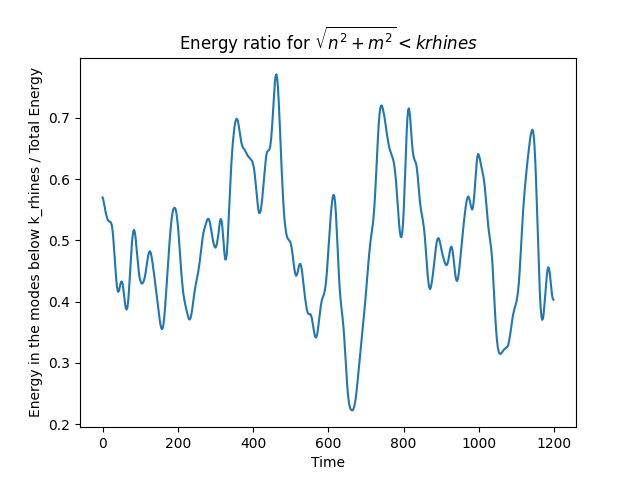

0.4978710456469404


In [23]:
# Compute the magnitude of the wave numbers

N  = np.shape(q)[-1]
m_axis = np.arange(1, int(n_rhines*1.3), 1)
n_axis = np.arange(1, int(n_rhines*1.3), 1)

M_mat,N_mat = np.meshgrid(m_axis,n_axis)
mode_mag = np.sqrt(M_mat**2 + N_mat**2)
mask = np.zeros_like(mode_mag)
mask[mode_mag<n_rhines*1.2]=1
# Filter out the energies for k < krhines
energy_filtered = E_mn_2D*mask
print(np.shape(E_mn_2D))

# Sum the total energy for the filtered values
total_energy_modes = np.sum(energy_filtered,axis=(1,2))
#Calculating the total energy
dx=x[-1]/x.shape[0]
total_energy=op.calc_en(psi[time_sel,:,:], q[time_sel,:,:],dx,bc_fac=bc_fac)/Lx**2

plt.figure()
plt.plot(time_sel,total_energy_modes/total_energy)
plt.xlabel('Time')
plt.ylabel('Energy in the modes below k_rhines / Total Energy')
plt.title('Energy ratio for $\\sqrt{n^2 + m^2} < krhines$')
plt.savefig('figures/Energy_diags/Energy_total'+str(simu_name)+'.png')
plt.show()

print(np.mean(total_energy_modes/total_energy))

In [25]:
# Step 1: Compute the mean of `q` along the specified axis (assuming axis=0)
q_mean = np.mean(q, axis=0)

# Step 2: Repeat the mean array for each time step in `t`
q_mean_repeated = np.repeat(q_mean[np.newaxis, ...], len(t), axis=0)

# Print the shape of the new array to verify
print(q_mean_repeated.shape)
# Create lists for results
results = Parallel(n_jobs=-1)(
    delayed(compute_for_mn)(m, n, q_mean_repeated, time_sel, Lx)
    for m in m_range
    for n in n_range
)

# Unpack results
E_list_mn = []
sqrt_list = []

E_mn_2D = np.zeros((len(time_sel),len(m_range), len(n_range)))

for (E_mn, sqrt_mn), m, n in zip(results, m_range, n_range):
    E_mn_2D[:,m-1, n-1] = E_mn
    E_list_mn.append(E_mn)
    sqrt_list.append(sqrt_mn)

print("Computation complete.")

(1200, 256, 256)
Computation complete.


(600, 11, 11)


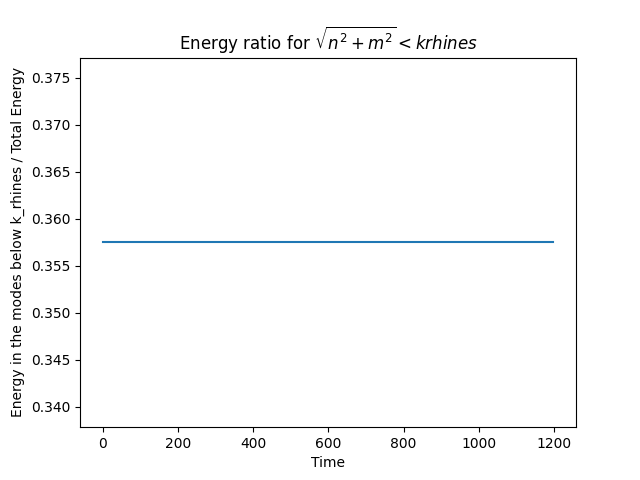

In [26]:
# Compute the magnitude of the wave numbers

N  = np.shape(q)[-1]
m_axis = np.arange(1, int(n_rhines*1.3), 1)
n_axis = np.arange(1, int(n_rhines*1.3), 1)

M_mat,N_mat = np.meshgrid(m_axis,n_axis)
mode_mag = np.sqrt(M_mat**2 + N_mat**2)
mask = np.zeros_like(mode_mag)
mask[mode_mag<n_rhines*1.2]=1
# Filter out the energies for k < krhines
energy_filtered = E_mn_2D*mask
print(np.shape(E_mn_2D))

# Sum the total energy for the filtered values
total_energy_modes = np.sum(energy_filtered,axis=(1,2))
total_energy = np.sum(E_mn_2D,axis=(1,2))
plt.figure()
plt.plot(time_sel,total_energy_modes/total_energy)
plt.xlabel('Time')
plt.ylabel('Energy in the modes below k_rhines / Total Energy')
plt.title('Energy ratio for $\\sqrt{n^2 + m^2} < krhines$')
plt.savefig('figures/Energy_diags/Energy_total'+str(simu_name)+'.png')
plt.show()